# SemlaFlow: Interactive 3D Molecule Generation Demo

This notebook provides an interactive demonstration of SemlaFlow, a framework for generating 3D molecular structures using flow matching and equivariant neural networks.

## What is SemlaFlow?

SemlaFlow combines:
- **Flow Matching**: A continuous-time generative modeling approach that learns vector fields by matching trajectories
- **Equivariant Attention Networks**: Neural networks that respect the 3D symmetries of molecular structures
- **Optimal Transport**: For aligning molecular structures efficiently

## Setup & Imports

In [57]:
import os
import sys
import torch
import py3Dmol
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt

from rdkit import Chem
from tqdm.notebook import tqdm
from IPython.display import display
from rdkit.Chem import Draw, AllChem
from ipywidgets import interact, fixed

if '..' not in sys.path: sys.path.append('..')

import semlaflow.scriptutil as util
import semlaflow.util.functional as smolF

from semlaflow.models.fm import Integrator, MolecularCFM
from semlaflow.data.interpolate import GeometricNoiseSampler
from semlaflow.models.semla import EquiInvDynamics, SemlaGenerator
from semlaflow.util.molrepr import GeometricMolBatch, GeometricMol

## Load Pretrained Model

Configure below as needed

In [58]:
MODEL_PATH = "../models/300epochs.ckpt"
DATASET = "qm9"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 10
print(f"Using device: {DEVICE} with BATCH_SIZE={BATCH_SIZE}")

def load_model(model_path, vocab):
    """Load pretrained model from checkpoint"""
    checkpoint = torch.load(model_path, map_location=DEVICE)
    hparams = checkpoint["hyper_parameters"]
    
    # Configure model parameters
    hparams["compile_model"] = False
    n_bond_types = util.get_n_bond_types(hparams["integration-type-strategy"])
    
    # Set architecture (default to semla if not specified)
    if hparams.get("architecture") is None: hparams["architecture"] = "semla"
    
    # Build generator based on architecture
    if hparams["architecture"] == "semla":
        dynamics = EquiInvDynamics(
            hparams["d_model"],
            hparams["d_message"],
            hparams["n_coord_sets"],
            hparams["n_layers"],
            n_attn_heads=hparams["n_attn_heads"],
            d_message_hidden=hparams["d_message_hidden"],
            d_edge=hparams["d_edge"],
            self_cond=hparams["self_cond"],
            coord_norm=hparams["coord_norm"],
        )
        generator = SemlaGenerator(
            hparams["d_model"],
            dynamics,
            vocab.size,
            hparams["n_atom_feats"],
            d_edge=hparams["d_edge"],
            n_edge_types=n_bond_types,
            self_cond=hparams["self_cond"],
            size_emb=hparams["size_emb"],
            max_atoms=hparams["max_atoms"]
        )
    else:
        raise ValueError(f"Architecture {hparams['architecture']} not supported in this demo")
    
    # Determine mask index if using masking strategy
    type_mask_index = (
        vocab.indices_from_tokens(["<MASK>"])[0] if hparams["integration-type-strategy"] == "mask" else None
    )
    bond_mask_index = None
    
    # Create integrator
    integration_steps = 100
    integrator = Integrator(
        integration_steps,
        type_strategy=hparams["integration-type-strategy"],
        bond_strategy=hparams["integration-bond-strategy"],
        type_mask_index=type_mask_index,
        bond_mask_index=bond_mask_index,
        cat_noise_level=1.0,
    )
    
    # Load model from checkpoint
    model = MolecularCFM.load_from_checkpoint(
        model_path,
        map_location=DEVICE,
        gen=generator,
        vocab=vocab,
        integrator=integrator,
        type_mask_index=type_mask_index,
        bond_mask_index=bond_mask_index,
        **hparams,
    )
    
    model = model.to(DEVICE).eval()
    return model, hparams

vocab = util.build_vocab()
model, hparams = load_model(MODEL_PATH, vocab)

print(f"Model loaded successfully from {MODEL_PATH}")
print(f"Architecture: {hparams['architecture']}")
print(f"Model dimension: {hparams['d_model']}")
print(f"Coordinate sets: {hparams['n_coord_sets']}")
print(f"Number of layers: {hparams['n_layers']}")
print(f"Self-conditioning enabled: {model.self_condition}")

Using device: cuda with BATCH_SIZE=10
Model loaded successfully from ../models/300epochs.ckpt
Architecture: semla
Model dimension: 384
Coordinate sets: 64
Number of layers: 12
Self-conditioning enabled: True


## Basic Molecule Generation

Let's generate some molecules and visualize them in both 2D and 3D:

In [59]:
def create_prior_batch(model, n_atoms=15, batch_size=1):
    """Create a batch of prior noise molecules"""
    # Determine coord scale and dimensions
    coord_std = util.QM9_COORDS_STD_DEV if DATASET == "qm9" else util.GEOM_COORDS_STD_DEV
    n_bond_types = util.get_n_bond_types(model.hparams["integration-type-strategy"])
    
    # Create noise sampler
    prior_sampler = GeometricNoiseSampler(
        vocab.size,
        n_bond_types,
        coord_noise="gaussian",
        type_noise="uniform-sample",
        bond_noise="uniform-sample",
        scale_ot=False,
        zero_com=True,
        type_mask_index=model.type_mask_index,
        bond_mask_index=model.bond_mask_index
    )
    
    # Sample batch
    batch = prior_sampler.sample_batch([n_atoms] * batch_size)
    
    # Convert to dictionary format and ensure proper dtypes
    data = {
        "coords": batch.coords.to(DEVICE) / coord_std,
        "atomics": batch.atomics.to(DEVICE),
        "bonds": batch.adjacency.to(DEVICE),
        "charges": batch.charges.to(DEVICE),
        "mask": batch.mask.long().to(DEVICE)  # Ensure mask is long type, for some reason it breaks if it isn't set to `long`
    }
    
    return data

def generate_molecules(model, n_molecules=5, n_atoms=15, steps=100, strategy="log", noise_level=1.0):
    """Generate molecules using the model"""
    model.integrator.steps = steps
    model.integrator.cat_noise_level = noise_level
    
    # Generate molecules in batches
    batch_size = min(n_molecules, BATCH_SIZE)
    batches = (n_molecules + batch_size - 1) // batch_size
    
    all_molecules = []
    all_raw_outputs = []
    
    for _ in tqdm(range(batches)):
        # Adjust batch size for last batch
        current_batch_size = min(batch_size, n_molecules - len(all_molecules))
        if current_batch_size <= 0:
            break
            
        # Create prior noise and generate molecules
        batch = create_prior_batch(model, n_atoms=n_atoms, batch_size=current_batch_size)
        with torch.no_grad():
            output = model._generate(batch, steps, strategy)
            molecules = model._generate_mols(output)
        
        all_molecules.extend(molecules)
        all_raw_outputs.append(output)
    
    # Filter out None molecules
    valid_molecules = [mol for mol in all_molecules if mol is not None]
    print(f"Generated {len(valid_molecules)} valid molecules out of {n_molecules} attempts")
    
    return valid_molecules, all_raw_outputs

In [60]:
# Generate molecules
n_molecules = 9
molecules, raw_outputs = generate_molecules(model, n_molecules=n_molecules, n_atoms=15, steps=100)

  0%|          | 0/1 [00:00<?, ?it/s]

Generated 9 valid molecules out of 9 attempts


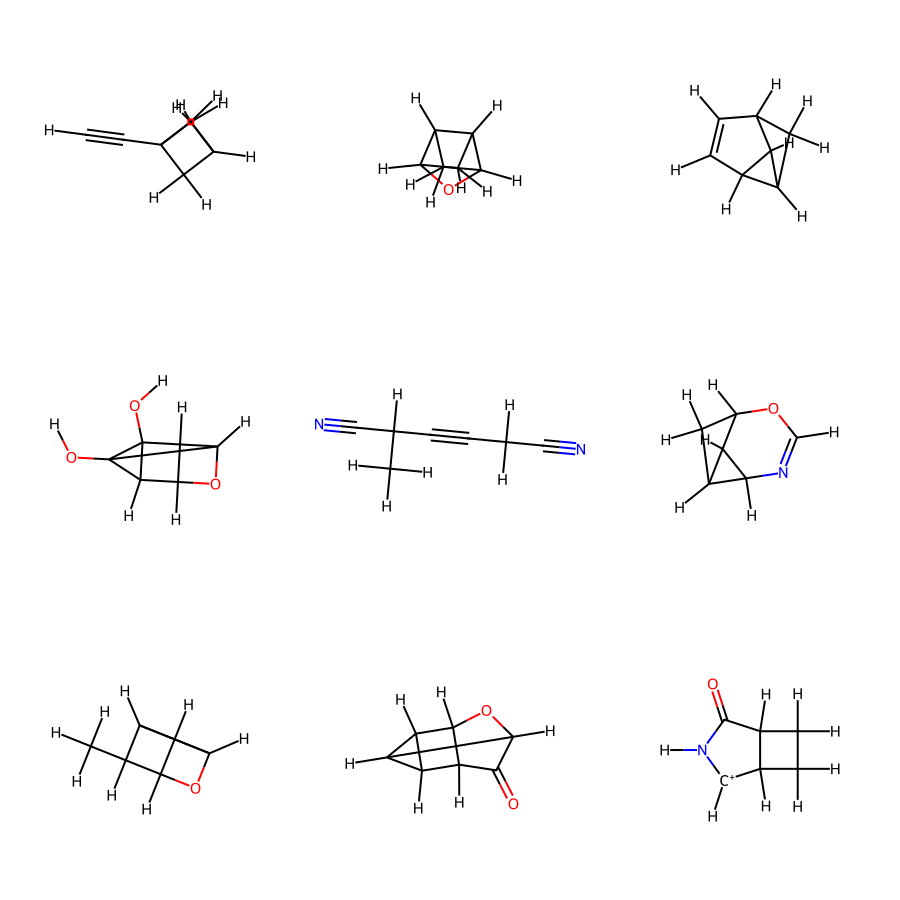

In [61]:
# Display 2D representations
if molecules:
    viz_mols = []
    for mol in molecules:
        mol_copy = Chem.Mol(mol)
        mol_copy = Chem.AddHs(mol_copy, addCoords=True)
        AllChem.Compute2DCoords(mol_copy)
        viz_mols.append(mol_copy)
    
    # Display in grid
    img = Draw.MolsToGridImage(viz_mols, molsPerRow=3, subImgSize=(300, 300))
    display(img)
else:
    print("No valid molecules were generated.")

## 3D Visualization

Now let's visualize these molecules in 3D using py3Dmol:

In [62]:
def visualize_molecule_3d(mol, width=500, height=400, style='stick', surface=False, spin=False):
    """Visualize a molecule in 3D using py3Dmol"""
    if mol is None:
        return "Invalid molecule"
    
    # Prepare molecule - add hydrogens and generate 3D coordinates
    mol_copy = Chem.Mol(mol)
    mol_copy = Chem.AddHs(mol_copy, addCoords=True)
    
    # Optimize 3D coordinates if available
    try:
        AllChem.MMFFOptimizeMolecule(mol_copy)
    except:
        pass
    
    # Convert to molblock format for py3Dmol
    mb = Chem.MolToMolBlock(mol_copy)
    
    # Create 3D viewer
    view = py3Dmol.view(width=width, height=height)
    view.addModel(mb, 'mol')
    
    # Set style based on input parameter
    if style == 'stick':
        view.setStyle({'stick': {}})
    elif style == 'sphere':
        view.setStyle({'sphere': {}})
    elif style == 'cartoon':
        view.setStyle({'cartoon': {}})
    elif style == 'ball_and_stick':
        view.setStyle({'stick': {}, 'sphere': {'radius': 0.25}})
    
    # Add surface if requested
    if surface: view.addSurface(py3Dmol.VDW, {'opacity': 0.5, 'color': 'white'})
    # Set spin if requested
    if spin: view.spin(True)
    # Center and zoom view
    view.zoomTo()
    
    return view

# Create interactive widget for 3D visualization
@interact(
    molecule_index=widgets.IntSlider(min=0, max=max(0, len(molecules)-1), step=1, value=0, description='Molecule:'),
    style=widgets.Dropdown(options=['stick', 'sphere', 'ball_and_stick'], value='stick', description='Style:'),
    surface=widgets.Checkbox(value=False, description='Surface'),
    spin=widgets.Checkbox(value=False, description='Spin'),
    width=widgets.IntSlider(min=300, max=800, step=50, value=500, description='Width:'),
    height=widgets.IntSlider(min=300, max=800, step=50, value=400, description='Height:')
)
def view_molecule(molecule_index, style, surface, spin, width, height):
    """Interactive function to view molecules in 3D"""
    if not molecules or molecule_index >= len(molecules):
        return "No molecule available"
    
    mol = molecules[molecule_index]
    view = visualize_molecule_3d(mol, width, height, style, surface, spin)
    
    # Calculate and display some properties
    from rdkit.Chem import Descriptors, QED
    try:
        props = {
            "Formula": Chem.rdMolDescriptors.CalcMolFormula(mol),
            "Molecular Weight": round(Descriptors.MolWt(mol), 2),
            "LogP": round(Descriptors.MolLogP(mol), 2),
            "H-Bond Donors": Descriptors.NumHDonors(mol),
            "H-Bond Acceptors": Descriptors.NumHAcceptors(mol),
            "Rotatable Bonds": Descriptors.NumRotatableBonds(mol),
            "QED (drug-likeness)": round(QED.qed(mol), 3)
        }
        prop_str = "<br>".join([f"<b>{k}:</b> {v}" for k, v in props.items()])
        display(widgets.HTML(f"<div style='margin-top: 10px;'><h4>Properties:</h4>{prop_str}</div>"))
    except:
        display(widgets.HTML("<div>Error calculating properties</div>"))
    
    return view

interactive(children=(IntSlider(value=0, description='Molecule:', max=8), Dropdown(description='Style:', optio…

## Flow Trajectory Visualization

One of the most interesting aspects of flow matching is the linear interpolation from noise to a final datapoint (valid molecule). Let's visualize this process:

In [66]:
def generate_trajectory(model, n_atoms=15, n_steps=10, strategy="log"):
    """Generate a trajectory of molecules from noise to final structure"""
    # Create prior noise
    prior = create_prior_batch(model, n_atoms=n_atoms, batch_size=1)

    # Sample at different time points
    trajectory = []
    timesteps = []

    # Determine time points based on strategy
    if strategy == "linear":
        time_points = np.linspace(0, 1, n_steps+1)[:-1]  # Exclude t=1 (end point)
    elif strategy == "log":
        time_points = (1 - np.geomspace(0.01, 1.0, n_steps+1))[:-1]  # Exclude t=1 (end point)
        time_points = time_points[::-1]  # Reverse to go from 0 to 1
    else:
        raise ValueError(f"Unknown ODE integration strategy '{strategy}'")

    # Add the end point manually
    time_points = list(time_points) + [0.999]

    print("Generating trajectory...")
    for t in tqdm(time_points):
        times = torch.tensor([t], device=DEVICE, dtype=torch.float32) # Same here, for some reason I have to ensure float32, otherwise it breaks
        curr = {k: v.clone() for k, v in prior.items()}

        with torch.no_grad():
            # Create conditioning batch with zeros if we're using self-conditioning
            if model.self_condition:
                cond_batch = {
                    "coords": torch.zeros_like(curr["coords"]),
                    "atomics": torch.zeros_like(curr["atomics"]),
                    "bonds": torch.zeros_like(curr["bonds"])
                }
            else:
                cond_batch = None

            # Use the model's forward method with conditioning
            coords, type_logits, bond_logits, charge_logits = model(curr, times, training=False, cond_batch=cond_batch)

            type_probs = torch.softmax(type_logits, dim=-1)
            bond_probs = torch.softmax(bond_logits, dim=-1)
            charge_probs = torch.softmax(charge_logits, dim=-1)
            predicted = {
                "coords": coords,
                "atomics": type_probs,
                "bonds": bond_probs,
                "charges": charge_probs,
                "mask": curr["mask"]
            }

        # Create molecule from current state
        mol = model._generate_mols(predicted)[0]
        trajectory.append(mol)
        timesteps.append(t)

    return trajectory, timesteps

# Generate a trajectory
trajectory, timesteps = generate_trajectory(model, n_atoms=15, n_steps=100)

Generating trajectory...


  0%|          | 0/101 [00:00<?, ?it/s]

[16:53:45] Explicit valence for atom # 6 H, 2, is greater than permitted
[16:53:45] Explicit valence for atom # 6 H, 2, is greater than permitted
[16:53:45] Explicit valence for atom # 6 H, 2, is greater than permitted
[16:53:45] Explicit valence for atom # 6 H, 2, is greater than permitted
[16:53:45] Explicit valence for atom # 6 H, 2, is greater than permitted
[16:53:45] Explicit valence for atom # 6 H, 2, is greater than permitted
[16:53:45] Explicit valence for atom # 6 H, 2, is greater than permitted
[16:53:45] Explicit valence for atom # 6 H, 2, is greater than permitted
[16:53:45] Explicit valence for atom # 6 H, 2, is greater than permitted
[16:53:45] Explicit valence for atom # 6 H, 2, is greater than permitted
[16:53:45] Explicit valence for atom # 6 H, 2, is greater than permitted
[16:53:45] Explicit valence for atom # 6 H, 2, is greater than permitted
[16:53:45] Explicit valence for atom # 6 H, 2, is greater than permitted
[16:53:45] Explicit valence for atom # 6 H, 2, is g

In [70]:
# Create interactive widget to view trajectory
@interact(
    timestep=widgets.IntSlider(min=0, max=len(trajectory)-1, step=1, value=0, description='Time step:'),
    style=widgets.Dropdown(options=['stick', 'sphere', 'ball_and_stick'], value='stick', description='Style:'),
    width=fixed(600),
    height=fixed(400),
    surface=fixed(False),
    spin=fixed(False)
)
def view_trajectory(timestep, style, width, height, surface, spin):
    """View a specific timestep in the trajectory"""
    if not trajectory or timestep >= len(trajectory):
        return "No trajectory available"
    
    mol = trajectory[timestep]
    t = timesteps[timestep]
    
    print(f"Viewing time t = {t:.3f}")
    
    if mol is None: 
        return "Invalid Molecule"
    
    return visualize_molecule_3d(mol, width, height, style, surface, spin)

interactive(children=(IntSlider(value=0, description='Time step:'), Dropdown(description='Style:', options=('s…

## Side-by-Side Trajectory View

Let's visualize multiple timesteps of the trajectory together to see the evolution:

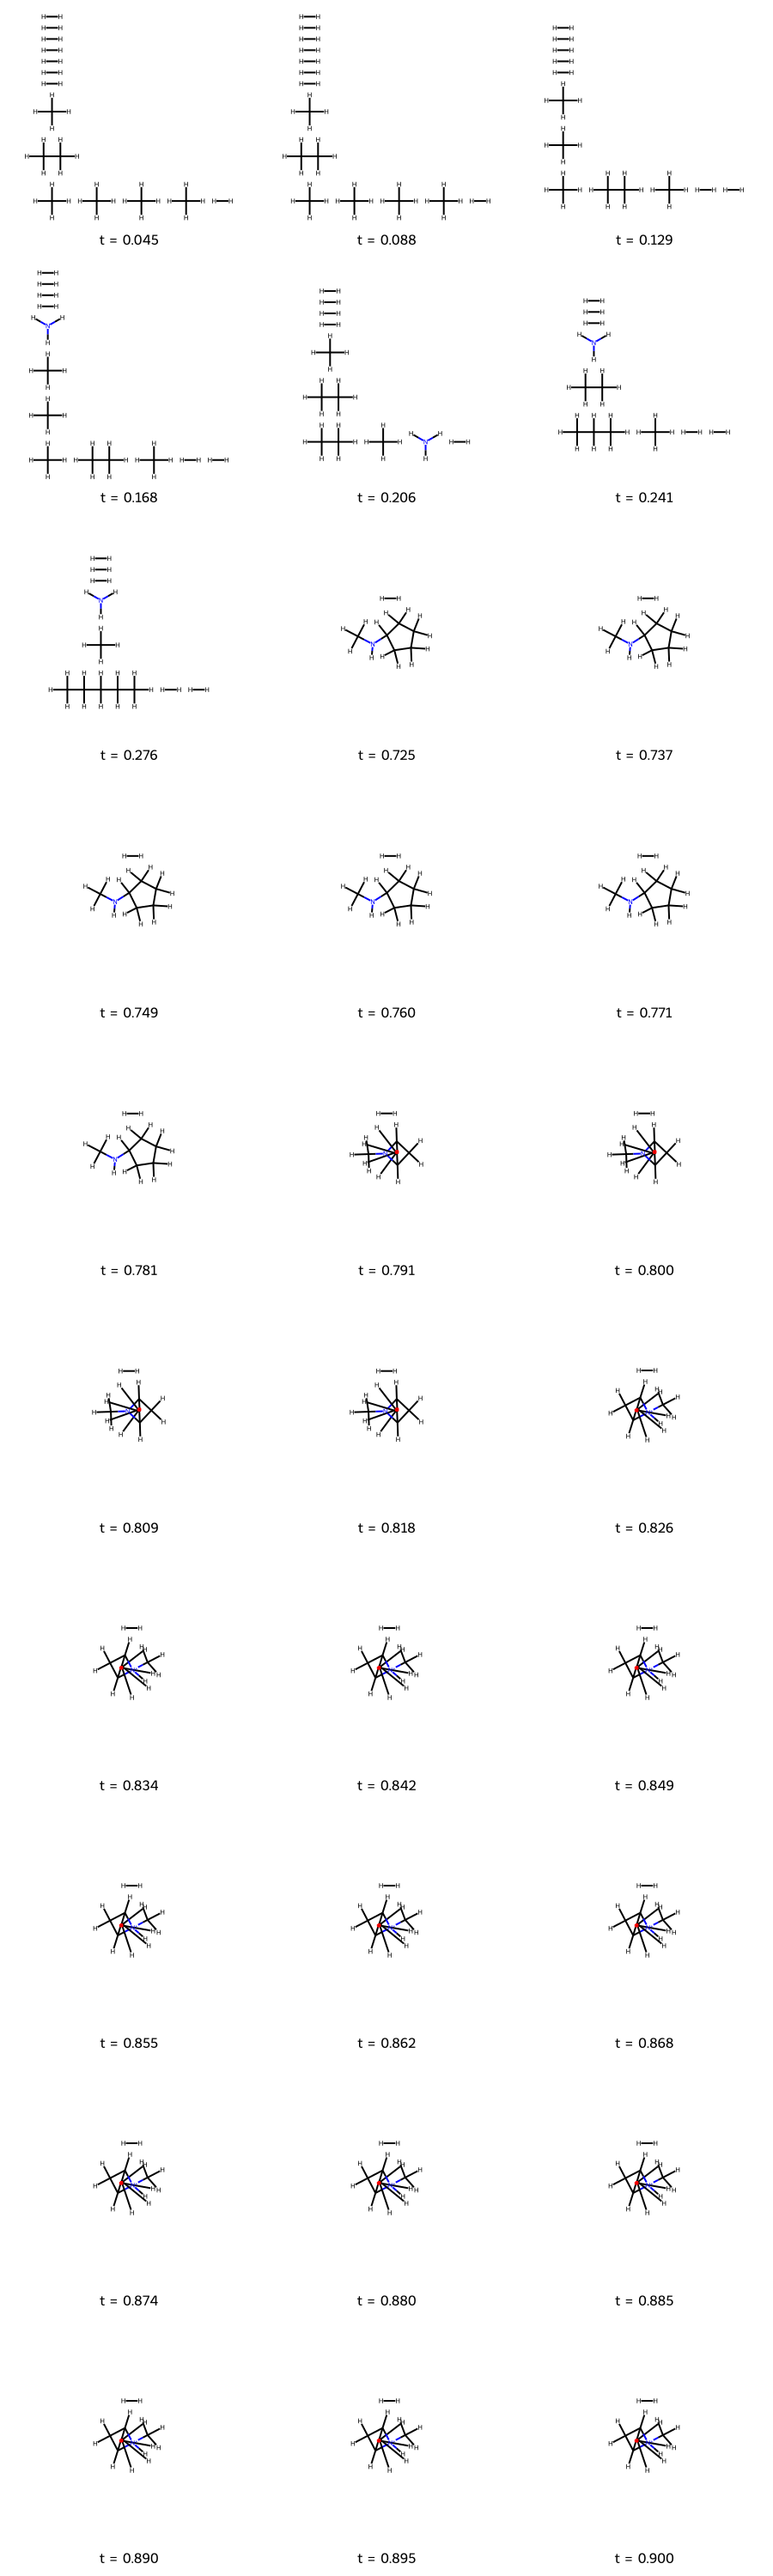

In [71]:
def display_trajectory_grid(trajectory, timesteps, n_cols=3):
    """Display a grid of molecules from the trajectory"""
    if not trajectory:
        print("No trajectory available")
        return
    
    # Filter out None molecules
    valid_traj = [(mol, t) for mol, t in zip(trajectory, timesteps) if mol is not None]
    if not valid_traj:
        print("No valid molecules in trajectory")
        return
    
    mols, times = zip(*valid_traj)
    
    # Prepare molecules for grid visualization
    viz_mols = []
    for mol in mols:
        mol_copy = Chem.Mol(mol)
        Chem.SanitizeMol(mol_copy)
        mol_copy = Chem.AddHs(mol_copy, addCoords=True)
        AllChem.Compute2DCoords(mol_copy)
        viz_mols.append(mol_copy)
    
    # Create labels with timesteps
    labels = [f"t = {t:.3f}" for t in times]
    
    # Calculate grid dimensions
    n_mols = len(viz_mols)
    n_rows = (n_mols + n_cols - 1) // n_cols
    
    # Display in grid
    img = Draw.MolsToGridImage(viz_mols, molsPerRow=n_cols, subImgSize=(300, 300), legends=labels)
    display(img)

# Display trajectory grid
display_trajectory_grid(trajectory, timesteps)

## Interactive Molecule Generation

Let's create an interactive interface to generate molecules with different parameters:

In [72]:
@interact(
    n_molecules=widgets.IntSlider(min=1, max=16, step=1, value=4, description='Number:'),
    n_atoms=widgets.IntSlider(min=1, max=30, step=1, value=15, description='Atoms:'),
    steps=widgets.IntSlider(min=1, max=200, step=10, value=100, description='Steps:'),
    strategy=widgets.Dropdown(options=['linear', 'log'], value='log', description='Strategy:'),
    noise_level=widgets.FloatSlider(min=0.1, max=2.0, step=0.1, value=1.0, description='Noise:'),
    molsPerRow=widgets.IntSlider(min=1, max=8, step=1, value=3, description='Cols:')
)
def generate_molecules_interactive(n_molecules, n_atoms, steps, strategy, noise_level, molsPerRow):
    """Interactive function to generate molecules with different parameters"""
    # Generate molecules
    molecules, _ = generate_molecules(
        model,
        n_molecules=n_molecules, 
        n_atoms=n_atoms, 
        steps=steps, 
        strategy=strategy,
        noise_level=noise_level
    )
    
    if not molecules:
        print("No valid molecules were generated.")
        return
    
    # Prepare molecules for visualization
    viz_mols = []
    for mol in molecules:
        mol_copy = Chem.Mol(mol)
        mol_copy = Chem.AddHs(mol_copy, addCoords=True)
        AllChem.Compute2DCoords(mol_copy)
        viz_mols.append(mol_copy)
    
    # Display in grid
    img = Draw.MolsToGridImage(viz_mols, molsPerRow=molsPerRow, subImgSize=(300, 300))
    display(img)

interactive(children=(IntSlider(value=4, description='Number:', max=16, min=1), IntSlider(value=15, descriptio…

## Property Analysis of Generated Molecules

Let's analyze the properties of a larger batch of generated molecules to see the distribution:

In [73]:
def analyze_molecules(molecules):
    """Analyze molecular properties of a batch of molecules"""
    if not molecules:
        print("No molecules to analyze")
        return
        
    import pandas as pd
    from rdkit.Chem import Descriptors, QED, Lipinski
    
    # Calculate properties
    properties = []

    # Filter None mols
    mol = [mol for mol in molecules if mol is not None]
    
    for mol in molecules:
        try:
            props = {
                'MW': Descriptors.MolWt(mol),
                'LogP': Descriptors.MolLogP(mol),
                'HBA': Descriptors.NumHAcceptors(mol),
                'HBD': Descriptors.NumHDonors(mol),
                'TPSA': Descriptors.TPSA(mol),
                'RotBonds': Descriptors.NumRotatableBonds(mol),
                'QED': QED.qed(mol),
                'Num Atoms': mol.GetNumAtoms(),
                'Num Rings': Chem.rdMolDescriptors.CalcNumRings(mol)
            }
            properties.append(props)
        except:
            continue
    
    # Display statistics
    print(f"Analyzed {len(properties)} valid molecules")
    df = pd.DataFrame(properties)
    display(df.describe())
    
    # Plot distributions
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    axes = axes.flatten()
    
    for i, col in enumerate(df.columns):
        if i >= len(axes):
            break
        axes[i].hist(df[col], bins=15, alpha=0.7)
        axes[i].set_title(col)
        axes[i].set_xlabel('Value')
        axes[i].set_ylabel('Count')
    
    plt.tight_layout()
    plt.show()
    
    return df

  0%|          | 0/5 [00:00<?, ?it/s]

Generated 50 valid molecules out of 50 attempts
Analyzed 50 valid molecules


,MW,LogP,HBA,HBD,TPSA,RotBonds,QED,Num Atoms,Num Rings
count,50.00000,50.000000,50.00000,50.000000,50.000000,50.000000,50.000000,50.0,50.000000
mean,116.50112,-0.339061,2.34000,0.880000,44.675800,1.280000,0.424802,15.0,1.840000
std,12.87571,1.109097,0.93917,0.895339,21.044367,1.107304,0.068235,0.0,1.113186
min,70.13500,-3.258700,0.00000,0.000000,0.000000,0.000000,0.237517,15.0,0.000000
25%,109.12800,-0.993375,2.00000,0.000000,31.890000,0.250000,0.379995,15.0,1.000000
50%,122.12300,-0.161650,2.00000,1.000000,42.115000,1.000000,0.427314,15.0,2.000000
75%,126.11400,0.303325,3.00000,1.000000,60.382500,2.000000,0.466644,15.0,2.000000
max,143.10200,1.896440,4.00000,3.000000,97.790000,5.000000,0.571258,15.0,5.000000


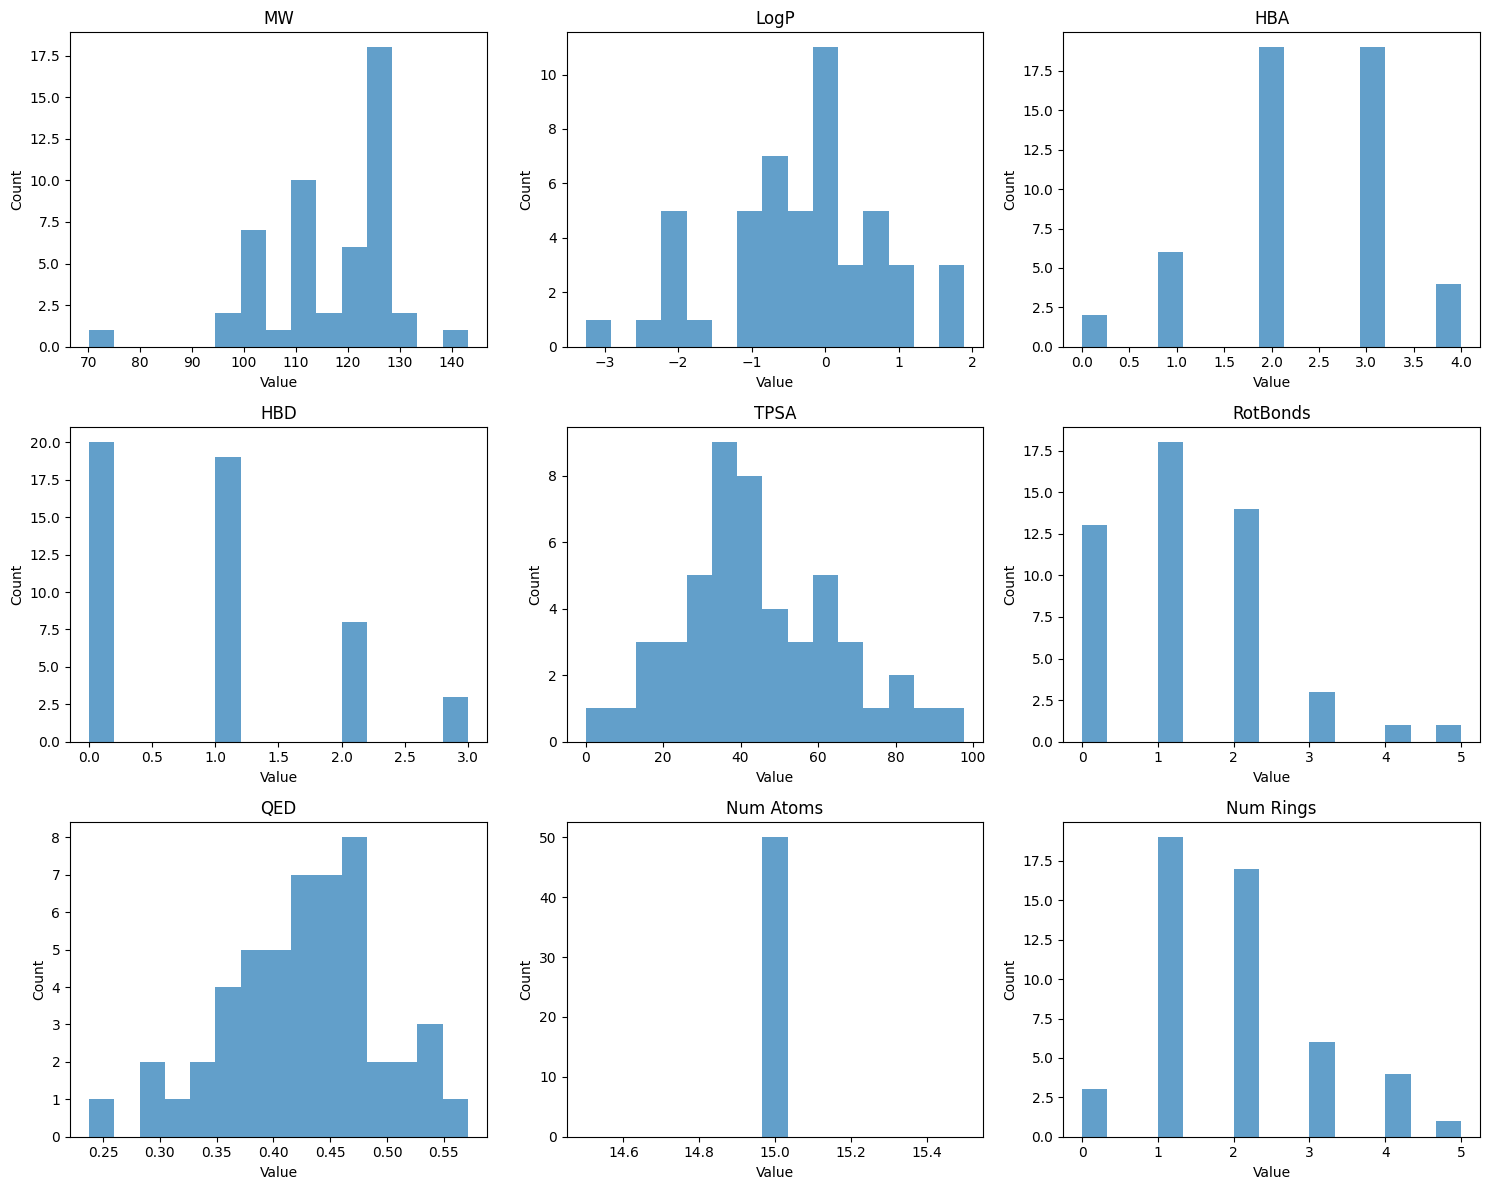

In [76]:
# Generate a larger batch of molecules for analysis
analysis_molecules, _ = generate_molecules(model, n_molecules=50, n_atoms=15, steps=100)
# Note, would be nice to be able to generate $n$ molecules but with different `n_atoms`, but unsure!

# Analyze properties
molecule_properties = analyze_molecules(analysis_molecules)

## Visualizing Attention Patterns

Let's try to visualize the attention patterns to understand how the model "thinks" when generating molecules:

In [77]:
def extract_attention_weights(model, mol_index=0, layer_index=0):
    """Extract attention weights from a model for a specific molecule"""
    # This is a simplified approximation as we can't directly access attention weights
    # We'll use bond types as a proxy for attention
    
    if not hasattr(model, '_last_generated_batch'):
        # Generate a molecule to get attention patterns
        print("Generating a molecule to extract attention patterns...")
        prior = create_prior_batch(model, n_atoms=15, batch_size=1)
        with torch.no_grad():
            output = model._generate(prior, 100, "log")
        model._last_generated_batch = output
    
    # Extract bond distributions from the output
    bond_dists = model._last_generated_batch["bonds"][mol_index].cpu().numpy()
    
    # Combine all bond types into a single attention weight
    # Use the sum of non-zero bond probabilities
    attention = np.sum(bond_dists[:, :, 1:], axis=2)  # Skip the first bond type (no bond)
    
    return attention

def visualize_attention(mol, attention_weights, threshold=0.3, width=600, height=500):
    """Visualize attention between atoms in a molecule"""
    if mol is None:
        return "Invalid molecule"
    
    # Prepare molecule - add hydrogens and generate 3D coordinates
    mol_copy = Chem.Mol(mol)
    mol_copy = Chem.AddHs(mol_copy, addCoords=True)
    
    # Optimize 3D coordinates
    try:
        AllChem.MMFFOptimizeMolecule(mol_copy)
    except:
        pass
    
    # Get atom positions
    conf = mol_copy.GetConformer()
    n_atoms = mol_copy.GetNumAtoms()
    
    # Set up the 3D viewer
    view = py3Dmol.view(width=width, height=height)
    mb = Chem.MolToMolBlock(mol_copy)
    view.addModel(mb, 'mol')
    view.setStyle({'stick': {}, 'sphere': {'radius': 0.3}})
    
    # Limit attention weights to atoms in the molecule
    effective_n = min(attention_weights.shape[0], n_atoms)
    
    # Add cylinders for attention connections
    max_weight = np.max(attention_weights)
    for i in range(effective_n):
        for j in range(i+1, effective_n):
            weight = attention_weights[i, j] / max_weight
            
            if weight > threshold:
                atom_i_pos = conf.GetAtomPosition(i)
                atom_j_pos = conf.GetAtomPosition(j)
                
                # Color based on weight (red for strong, blue for weak)
                red = min(1.0, weight * 2)
                blue = max(0.0, 1.0 - weight * 2)
                color = f'rgb({int(red*255)},0,{int(blue*255)})'
                view.addCylinder({
                    'start': {'x': atom_i_pos.x, 'y': atom_i_pos.y, 'z': atom_i_pos.z},
                    'end': {'x': atom_j_pos.x, 'y': atom_j_pos.y, 'z': atom_j_pos.z},
                    'radius': weight * 0.15,  # Scale weight for visualization
                    'color': color,
                    'fromCap': True,
                    'toCap': True,
                    'opacity': 0.7
                })
    
    view.zoomTo()
    return view

In [79]:
# Generate a new molecule to get fresh attention patterns
if hasattr(model, '_last_generated_batch'):
    del model._last_generated_batch

attn_molecules, _ = generate_molecules(model, n_molecules=1, n_atoms=15, steps=100)
if attn_molecules:
    mol = attn_molecules[0]    
    attention = extract_attention_weights(model)
    @interact(
        threshold=widgets.FloatSlider(min=0.1, max=0.9, step=0.05, value=0.5, description='Threshold:'),
        width=fixed(600),
        height=fixed(500)
    )
    def view_attention(threshold, width, height):
        """View attention patterns with adjustable threshold"""
        return visualize_attention(mol, attention, threshold, width, height)
else:
    print("Failed to generate a molecule for attention visualization")

  0%|          | 0/1 [00:00<?, ?it/s]

Generated 1 valid molecules out of 1 attempts
Generating a molecule to extract attention patterns...


interactive(children=(FloatSlider(value=0.5, description='Threshold:', max=0.9, min=0.1, step=0.05), Output())…

## Conclusion

In this notebook, we've explored SemlaFlow's capabilities for 3D molecular generation using flow matching. The key features we've demonstrated include:

1. **Basic Molecule Generation**: Using pretrained models to generate valid 3D molecular structures
2. **Interactive 3D Visualization**: Exploring generated molecules in 3D using py3Dmol
3. **Flow Trajectories**: Visualizing the gradual transformation from noise to molecule
4. **Property Analysis**: Analyzing the chemical properties of generated molecules
5. **Attention Patterns**: Getting insights into how the model's attention mechanism works


SemlaFlow combines equivariant neural networks and flow matching to create a powerful framework for molecular generation that respects the 3D nature of chemical structures.